# Imports

In [1]:
from haystack import Pipeline
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.builders import PromptBuilder

import os
from jd_custom_components import *

# Configuration and prompt

Use this section to configure the project and how it will run. This is also where you will write the prompt template.

In [2]:
OLLAMA_MODEL_NAME = "llama3:instruct"
OLLAMA_END_POINT = "http://llm_host:11434" # This is a debug endpoint with full logging
COMPANY_NAME = "www.118118money.com"
PAGES_TO_FETCH = 3
STARS = 1 # Set to none for no star filter

prompt_template = get_prompt_template_by_name("prompt-reviews-one-by-one")
print(prompt_template)

# IDENTITY and PURPOSE

You are an expert at evaluating reviews.

Take a step back and think step-by-step about how to achieve the best outcome by following the STEPS below.

# STEPS

1. Fully digest and understand the content of the review and the tone of it.

2. Identify the star rating provided.

3. Identify key issue that was brought up in the review. This could be positive or negative thing.

4. Summarise the key issue into no more than 15 words.

5. Try to categorise the key issue into one of the following groups: customer service, speed, price/interest rate, application process, loan amount/credit limit, account access, issues on holiday, website issues, credit search problems or something else.

6. Evaluate the sentiment of the review. Review can be either `positive`, `negative` or `neutral`. Do this solely based on the content of the review.

# OUTPUT INSTRUCTIONS

- You output a valid JSON object with the following structure.

```json
{
    "sentiment": "(computed sentiment)"

In [3]:
review_urls = []

for i in range(PAGES_TO_FETCH):
    
    review_urls.append(construct_trustpilot_url(COMPANY_NAME, page=i+1, stars=STARS))
    
url_list = '\n'.join(review_urls)
print(f"Following urls will be evaluated: \n{url_list}")

Following urls will be evaluated: 
https://uk.trustpilot.com/review/www.118118money.com?sort=recency&stars=1
https://uk.trustpilot.com/review/www.118118money.com?sort=recency&page=2&stars=1
https://uk.trustpilot.com/review/www.118118money.com?sort=recency&page=3&stars=1


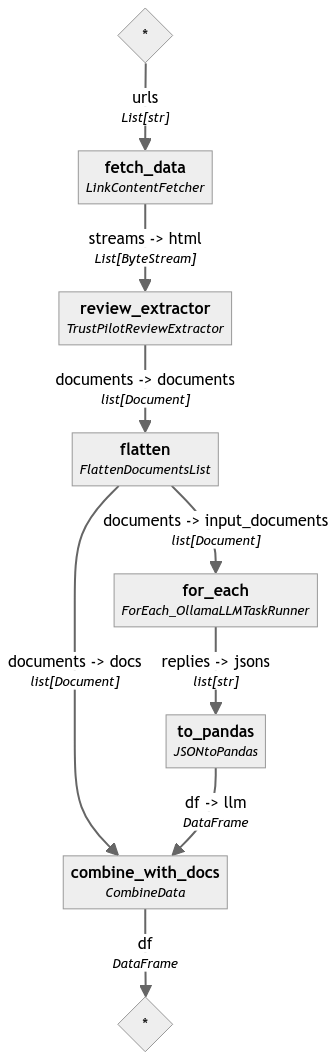

In [4]:
experiment_pipe = Pipeline()
experiment_pipe.add_component("fetch_data", LinkContentFetcher())
experiment_pipe.add_component("review_extractor", TrustPilotReviewExtractor(review_format="short"))
experiment_pipe.add_component("flatten", FlattenDocumentsList())

foreach_ollama_runner = ForEach_OllamaLLMTaskRunner(
    model_name=OLLAMA_MODEL_NAME,
    ollama_endpoint=OLLAMA_END_POINT,
    template=prompt_template,
    include_meta=False,
    generation_kwargs={"format":"json"},
)
experiment_pipe.add_component("for_each", foreach_ollama_runner)
experiment_pipe.add_component("to_pandas", JSONtoPandas())
experiment_pipe.add_component("combine_with_docs", CombineData())

experiment_pipe.connect("fetch_data.streams", "review_extractor.html")
experiment_pipe.connect("review_extractor.documents", "flatten")
experiment_pipe.connect("flatten", "for_each.input_documents")
experiment_pipe.connect("for_each", "to_pandas")

experiment_pipe.connect("to_pandas.df", "combine_with_docs.llm")
experiment_pipe.connect("flatten", "combine_with_docs.docs")

experiment_pipe.show()

In [5]:
res = experiment_pipe.run(
    data = {
        "fetch_data": {
            "urls":review_urls
        }
    },
    include_outputs_from=["flatten", "for_each", "to_pandas"]
)

100%|██████████| 60/60 [00:55<00:00,  1.08it/s]


In [6]:
os.makedirs("review_extractor", exist_ok=True)
res["combine_with_docs"]["df"].to_excel("review_extractor/reviews.xlsx")
res["combine_with_docs"]["df"]

,sentiment,key_issue,key_issue_category,star_rating,author_id,author_name,stars,headline,content,reply,date
0,negative,delayed delivery,speed,1.0,/users/6687117c86aa70596d703aaf,Mr. James Opoku,Rated 1 out of 5 stars,I applied for a credit card and was…,I applied for a credit card and was notified t...,,2024-06-18
1,negative,customer service is bad,customer service,1.0,/users/62bf16a05eb62f0012184c27,Ash,Rated 1 out of 5 stars,Absolute cowboys,"Absolute cowboys, customer help desk is a joke...",Reply from 118 118 MONEY\nHello Ash - thanks ...,2024-07-03
2,negative,untrustworthy and poor customer service,customer service,1.0,/users/64ef4382cb6b190012a45b84,Mathew Thomas,Rated 1 out of 5 stars,Awful company,"Awful company, believe me once they have your ...",Reply from 118 118 MONEY\nHello Matthew - I'm...,2024-07-03
3,negative,ruined credit score due to genuine mistake,customer service,1.0,/users/66853451836f3a5f8cd9365b,Jasper Libby,Rated 1 out of 5 stars,NEVER USE,Absolutely awful experience with 118.Paid off ...,"Reply from 118 118 MONEY\nHi Jasper, thanks f...",2024-07-02
4,negative,"unreliable app, poor customer service","customer service, speed",1.0,/users/5b9aef214de5666d34b34f4e,Tom Obemiaso,Rated 1 out of 5 stars,Stay clear of 118 money,"Stay clear of 118 money , credit cards or loan...","Reply from 118 118 MONEY\nHello Tom, thank yo...",2024-07-01
5,negative,aggressive debt chasing,customer service,1.0,/users/5ef3474ad9f9fa305970a609,David Holmes,Rated 1 out of 5 stars,Really poor,"Really poor, you miss a payment and the next d...","Reply from 118 118 MONEY\nHello David, Thank ...",2024-07-01
6,negative,credit card site problem,website issues,NaN,/users/6683a648078852695571de22,Mr. Kevin Mattammal Jacob,Rated 1 out of 5 stars,i didn't get the credit card site…,i didn't get the credit card site problem\n,Reply from 118 118 MONEY\nHi Kevin - thank yo...,2024-07-02
7,negative,poor service,customer service,1.0,/users/6678539275540f736b963287,Mrs. Udaya Kuntamukkala,Rated 1 out of 5 stars,Poor,Poor and worst\n,Reply from 118 118 MONEY\nHello - I'm sorry t...,2024-06-23
8,negative,unfair treatment by lender,customer service,1.0,/users/6676f73cd305a1f3d139191c,Fred,Rated 1 out of 5 stars,Loan agreement,Had a payment plan put in place for three mon...,Reply from 118 118 MONEY\nHello - thank you f...,2024-06-22
9,negative,unauthorized payments and poor customer service,customer service,1.0,/users/5fd46788ed74d7001a4b3dbc,Andy Jaszczyk,Rated 1 out of 5 stars,The worst company I have ever know,The worst company I have ever know. They take ...,Reply from 118 118 MONEY\nI am sorry to hear ...,2024-06-22


In [7]:
df = res["combine_with_docs"]["df"]

df. \
    groupby("key_issue_category", as_index=False). \
        agg(
            n = ("key_issue_category", "count")
        ). \
            assign(pct = lambda x: x.n / x.n.sum())

,key_issue_category,n,pct
0,account access,3,0.050000
1,application process,10,0.166667
2,credit search problems,4,0.066667
3,customer service,33,0.550000
4,"customer service, speed",1,0.016667
5,issues on holiday,2,0.033333
6,price/interest rate,1,0.016667
7,speed,5,0.083333
8,website issues,1,0.016667


/tmp/ipykernel_186/3872667206.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment="right")


[Text(0, 0, 'speed'),
 Text(1, 0, 'customer service'),
 Text(2, 0, 'customer service, speed'),
 Text(3, 0, 'website issues'),
 Text(4, 0, 'application process'),
 Text(5, 0, 'issues on holiday'),
 Text(6, 0, 'price/interest rate'),
 Text(7, 0, 'account access'),
 Text(8, 0, 'credit search problems')]

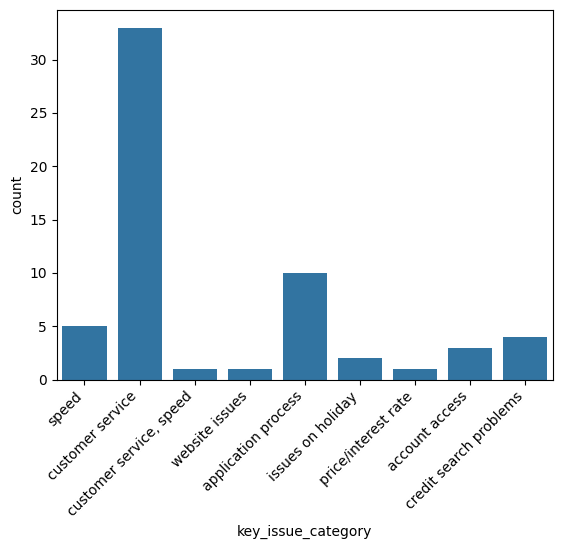

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

p = sns.countplot(data=df, x="key_issue_category")
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment="right")